# Introduction to source localization with beamformer

## Specification of imports and paths

Let's import the Python modules we will need and specify the paths to our data.

In [1]:
import numpy as np
import os.path as op

import mne
from mne.beamformer import make_lcmv, apply_lcmv

# plotting
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# path to our subject folders, subject name, and subject directory:
data_path = './example_data/bfws-dec2017/'
subject = 'sample'
subjects_dir = op.join(data_path, 'subjects/')

# save stuff here:
output_path = './output'

# paths to all the different files we need to load:
raw_fname = op.join(data_path, 'MEG', subject, 'flash_onoff_250Hz_raw.fif')  # raw data
t1_fname = op.join(subjects_dir, subject, 'mri/T1.mgz')  # T1 MRI
bem_fname = op.join(subjects_dir, subject, 'bem/sample-5120-5120-5120-bem-sol.fif')  # BEM model
trans_fname = op.join(data_path, 'MEG', subject, 'sample-trans.fif')  # coregistration matrix
fwd_fname = op.join(output_path, 'sample_vol-fwd-oct5.fif')  # forward model name to write forward model to disk

## Load the raw data file

Now we load the raw data and exclude one bad channel

In [3]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.info['bads'] = ['MEG2511']   # bad channel

Opening raw data file /home/britta/Dokumente/DATA_ANALYSIS/Beamforming/introduction_to_beamforming/example_data/bfws-dec2017/MEG/sample/flash_onoff_250Hz_raw.fif...
    Read a total of 8 projection items:
        mag_68.fif : PCA-v1 (1 x 306)  idle
        mag_68.fif : PCA-v2 (1 x 306)  idle
        mag_68.fif : PCA-v3 (1 x 306)  idle
        mag_68.fif : PCA-v4 (1 x 306)  idle
        mag_68.fif : PCA-v5 (1 x 306)  idle
        grad_68.fif : PCA-v1 (1 x 306)  idle
        grad_68.fif : PCA-v2 (1 x 306)  idle
        grad_68.fif : PCA-v3 (1 x 306)  idle
    Range : 32650 ... 109549 =    130.600 ...   438.196 secs
Ready.
Current compensation grade : 0
Reading 0 ... 76899  =      0.000 ...   307.596 secs...


## Forward model

Let's compute the forward model: We set up a volume source space, that means that the source grid will be covering the whole brain. The grid has a resolution of 10 mm, this means that we estimate source activity "every 10 mm".

We then compute the foward solution (leadfield) for all MEG channels (gradiometers and magnetometers) and save it to disk.

This takes some time!

In [4]:
# set up a volume source space
src = mne.setup_volume_source_space(subject, pos=10.,
                                    mri=t1_fname, bem=bem_fname)

# make leadfield
fwd = mne.make_forward_solution(raw.info, trans=trans_fname,
                                src=src, bem=bem_fname,
                                meg=True, eeg=False, n_jobs=1)

# let's save it to disk:
mne.write_forward_solution(fwd_fname, fwd, overwrite=True)



BEM file              : ./example_data/bfws-dec2017/subjects/sample/bem/sample-5120-5120-5120-bem-sol.fif
grid                  : 10.0 mm
mindist               : 5.0 mm
MRI volume            : ./example_data/bfws-dec2017/subjects/sample/mri/T1.mgz

Loaded inner skull from ./example_data/bfws-dec2017/subjects/sample/bem/sample-5120-5120-5120-bem-sol.fif (2562 nodes)
Surface CM = (   2.2  -18.0   -6.2) mm
Surface fits inside a sphere with radius   99.4 mm
Surface extent:
    x =  -70.9 ...   69.8 mm
    y = -106.7 ...   78.6 mm
    z =  -81.6 ...   76.5 mm
Grid extent:
    x =  -80.0 ...   70.0 mm
    y = -110.0 ...   80.0 mm
    z =  -90.0 ...   80.0 mm
5760 sources before omitting any.
3828 sources after omitting infeasible sources.
Source spaces are in MRI coordinates.
Checking that the sources are inside the bounding surface and at least    5.0 mm away (will take a few...)
1993 source space points omitted because they are outside the inner skull surface.
301 source space points omitt

<ipython-input-4-5857702bb1da>:11: RuntimeWarning: This filename (./output/sample_vol-fwd-oct5.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif or -fwd.fif.gz
  mne.write_forward_solution(fwd_fname, fwd, overwrite=True)


    Write a source space...
    [done]
    1 source spaces written


## Prepare data

To compute a covariance matrix, we need to epoch the data first: cut them into data snippets, aligned to the events/triggers.

In [5]:
# pick channels: we only use magnetometers here
raw.pick_types(meg='mag', stim=True, exclude='bads')

# find all trigger events in data:
events = mne.find_events(raw, stim_channel='STI101', shortest_event=1)

# correct for trigger delay (measured with a photo diode):
events[:, 0] += int(.01787 * raw.info['sfreq'])

# specify which trigger events we are looking for:
event_id = 255

# and how the data should be cut:
tmin, tmax = -.3, 0.3

# Let's apply baseline correction:
baseline = (-.3, -.05)

# finally, let's epoch the data:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline, preload=True)

115 events found
Events id: [192 240 252 255]
110 matching events found
Created an SSP operator (subspace dimension = 5)
8 projection items activated
Loading data for 110 events and 151 original time points ...
0 bad epochs dropped


## Visualize sensor data
Let's look at our epoched sensor data. For this, we quickly average across trials and plot the topography.

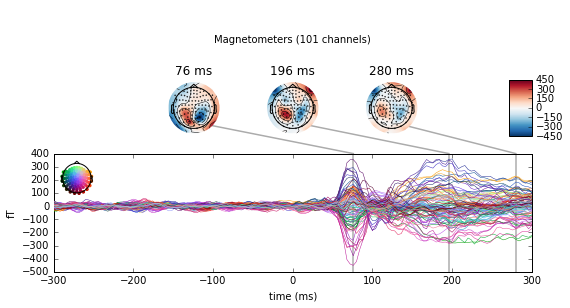

In [6]:
evoked = epochs.average()
evoked.plot_joint();

## Compute the data covariance matrix

For the computation of the beamformer, we need the data covariance matrix. Let's compute this on the brain activity between light onset and 300 ms after light onset.

We will plot the data covariance matrix and estimate it's _rank_ - to know whether we need regularization.

Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 8360
[done]
log-likelihood on unseen data (descending order):
   empirical: -662.944
selecting best estimator: empirical


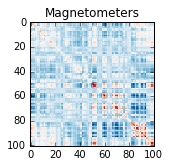

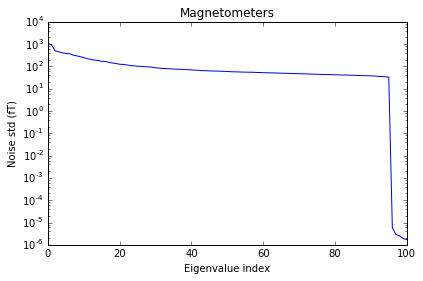

110 trials, 101 channels, covariance matrix has rank 96


In [7]:
# compute covariance matrix:
data_cov = mne.compute_covariance(epochs, tmin=0, tmax=0.3)

# plot data covariance matrix:
data_cov.plot(evoked.info)

# estimate the rank, get the number of channels and trials:
from mne.utils import estimate_rank
rank_cov = estimate_rank(data_cov['data'], tol='auto')
ch_num = len(data_cov.ch_names)
tr_num = len(epochs.events)

# print an informative message about the covariance quality :-) 
print("%i trials, %i channels, covariance matrix has rank %i" % (tr_num, ch_num, rank_cov))

## Compute the spatial filter

Now, let's compute the spatial filter = beamformer weights! 

We need some info from the data (e.g., included channels), the forward model and the data covariance for this.

We regularize with 5%, we do not include a noise covariance here, we pick the source orientation that maximizes our signal-to-noise ratio, and we use a special beamformer flavour, the Neural Activity Index (NAI) to correct for the depth bias.

_Note:_ While our forward model contains all channels, we only picked the magnetometers in our data -- hence the information about how many channels remain in our model!

In [8]:
lcmv_filt = make_lcmv(evoked.info, fwd, data_cov=data_cov, reg=0.05, noise_cov=None,
                      pick_ori='max-power', weight_norm='nai')


    101 out of 306 channels remain after picking


## Apply the spatial filter

After constructing our spatial filter, we can now apply it to our data!

We apply it to the evoked (averaged) data. Furthermore, we do not want to have power time series, therefore we specifiy ``max_ori_out='signed'``.)

In [9]:
stc = apply_lcmv(evoked, lcmv_filt, max_ori_out='signed')

## Visualize the source reconstructed signal

Finally, we can look at our results! 

First, we will look at our time series in the 30 voxels with maximum activity. Then, we will pick the maximum time point and plot the source activity of that time point on the subject's MRI!

**Maximum activity time series**

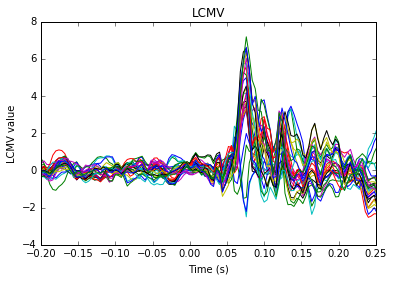

In [10]:
plt.figure()
# plot the time series of the 30 voxels with highest activity:
plt.plot(stc.times,
         stc.data[np.argsort(
            np.max(stc.data, axis=1))[-30:]].T)
# figure axes and title:
plt.xlabel('Time (s)')
plt.ylabel('LCMV value')
plt.xlim(-0.2, 0.25)
plt.title('LCMV')
# show figure
plt.show()

**Source map at maximum time point**

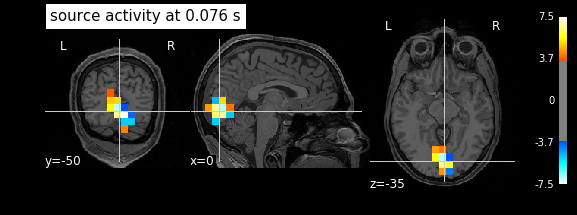

In [11]:
# whether activity at maximum time point should be plotted or own time point is chosen
plot_max_time = True

if plot_max_time:
    # get maximum time point
    [maxvox, maxtp] = np.unravel_index(stc.data.argmax(), stc.data.shape)
    # threshold for plotting: 50% of maximum value
    thresh = np.max(stc.data) * 0.5  
else:
    # choose time point
    maxtp = stc.time_as_index(0.100)
    # threshold at 50% maximum value of that chosen time point
    thresh = np.max(stc.data[:, maxtp]) * 0.5

    
# enable to plot power instead of signed values:
# stc.data[:, :] = np.abs(stc.data)

# plot the activity on the MRI
# (this requires saving the image to disk first)
img = mne.save_stc_as_volume('foo.nii.gz', stc, src, dest='mri', mri_resolution=False)
plot_stat_map(index_img(img, maxtp), t1_fname, threshold=thresh, 
              title='source activity at %.3f s' % stc.times[maxtp]);